## Time spent
- 12/7: 1:45, 1:00, 6:00

## Outline

- Directed Graph
- Directed Graph: Ordered
- Directed Graph: Ordered, Competitive

Methods
- Build nodes
- Add edges according to rules
- Calculate component sizes

# To-do
- Rewrite tarjan algorithms to work with tuples instead of defaultdicts
- Calculate component sizes of a graph with Tarjan algorithm
- Plot of largest SCC

Go though C++ tutorials linked to in Glotzdocs.

Speed up options:
- Multiprocessing and pool
- Cython

In [1]:
# Import needed packages
import time
import itertools
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# not yet installed
import networkx as nx
# import percolate

In [3]:
# For cleanliness, ignore warnings after first appearance. 
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

# 00 - Percolation implementations
### Network science background
- Erdos-Renyi graphs (random, non-directed graphs): [link here](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
- Directed Erdos-Renyi graphs, DER (directed edges)
- Paper covers two models:
  - Ordered, directed Erdos-Renyis (ODER)
  - Competitive ODER
  
I'm currently using Networkx to play around with these. In the generator source code [here](https://github.com/networkx/networkx/blob/1174e443263f8a60dc82083ad1c563a4c25e5582/networkx/generators/random_graphs.py), `erdos_renyi_graph` is just an alias for `gnp_random_graph`.

Algorithm for ODER:
- begin with a set of $n$ isolated nodes on which we have placed an arbitrarry ordering from 1 to $n$
- at each step, add a single directed edge between two nodes selected uniformly at random
    - the head of the directed edge = node higher in ordering
    - ...UNLESS the edge already exists in the graph
- repeat steps until $m$ edges have been added (edges and reverse edges count as separate edges)

In [4]:
def check_if_edge_exists(proposed,edges):
    for item in edges:
        if proposed==item: return True
        else: pass

In [5]:
# ODER implementation - tuples
def ODER(n,m):
    # set up list nodes with ranked order
    n_list = np.linspace(0,n-1,n).astype(int)

    # add m edges to the plot
    edge_list = []
    while len(edge_list)<m:
        first_node, second_node = random.sample(list(n_list),2)
        proposed_edge = tuple(sorted((first_node,second_node)))
        if check_if_edge_exists(proposed_edge,edge_list):
            if check_if_edge_exists(tuple(reversed(proposed_edge)),edge_list): pass
            else: edge_list.append(tuple(reversed(proposed_edge)))
        else: edge_list.append(proposed_edge)
    return edge_list

# C-ODER implementation - tuples
def CODER(n,m):
    # set up list nodes with ranked order
    n_list = np.linspace(0,n-1,n).astype(int)
    
    # add m edges to the plot
    edge_list = []
    while len(edge_list)<m:
        # samples without replacement (no duplicates)
        first_node, second_node, third_node = random.sample(list(n_list),3)
        proposed_edges = tuple(itertools.combinations(tuple(sorted((first_node,second_node,third_node))), 2))
        
        # for nodes with min difference, check if they/their reverse already exist; if no, add them
        difference = np.asarray([nodes[1]-nodes[0] for nodes in proposed_edges])
        idx = np.where(difference == difference.min())[0]
        for i in idx:
            proposed_edge = proposed_edges[i]
            # avoid duplicates; adds in reverse edges
            if check_if_edge_exists(proposed_edge,edge_list):
                if check_if_edge_exists(tuple(reversed(proposed_edge)),edge_list): pass
                else: edge_list.append(tuple(reversed(proposed_edge)))
            else: edge_list.append(proposed_edge)
    return edge_list    

Important! Should have an error if you ask for more edges than is possible to make...

In [6]:
edge_density = 3
n = 200
m = edge_density*n
print('Edge density: %s \nNumber of nodes: %s \nNumber of edges: %s' %(edge_density,n,m))
oder_test = ODER(n,m)

Edge density: 3 
Number of nodes: 200 
Number of edges: 600


In [21]:
'''
C-ODER is much slower than ODER because it has to do more iterations
Effectively, it's like having a lower MC probability
'''

edge_density = 50
n = 10**2
m = edge_density*n
print('Edge density: %s \nNumber of nodes: %s \nNumber of edges: %s' %(edge_density,n,m))
coder_test = CODER(n,m)

Edge density: 50 
Number of nodes: 100 
Number of edges: 5000


In [84]:
# Erdos Renyi from networkx as a point of comparison
# the acceptance probabiliy here is equivalent to the edge density
# Networkx generates a list of the n(n-1) possible edges
n = 10**2
p = 0.3
er = nx.erdos_renyi_graph(n,p,directed=True)
# print(er.nodes())
# print(er.edges())

### Problem: This is going to take a lot of compute power

Running for $10^3$ nodes is arlready overwhelming my computational power. The paper runs on $10^6$ nodes, so I have a lot of optimization to do... 

## Visualization
Yes, I can see if I can adapt networkx's draw capabilities.

I can also just make a covariance-like binary imshow to show what is connected to what.

In [82]:
def edges_to_viz(edges,n):
    viz_array = np.zeros((n,n))
    for i in edges:
        viz_array[i[0],i[1]]+=1
    return viz_array

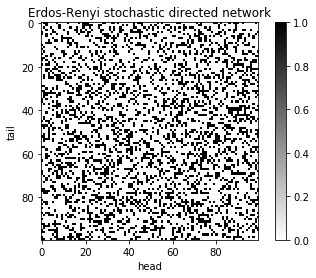

0.3006


In [89]:
# for now, just do a quick "is there an edge there" proof of concept
        
er_viz = edges_to_viz(er.edges(),n)

plt.imshow(er_viz,cmap='binary')
plt.title('Erdos-Renyi stochastic directed network')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()

print(np.sum(er_viz)/n**2)

In [ ]:
# Implementation of clustering algorithm from the paper

In [9]:
from collections import defaultdict

def edges_to_children(edges):
    children = defaultdict(list)
    for u,v in edges:
        children[u].append(v)
    return children

# Tarjan's algorithm
Playing around with an implementation from here: http://www.geeksforgeeks.org/tarjan-algorithm-find-strongly-connected-components/

This is honestly kinda like Hoshen Kopelman algorithm, but for networks. Good gif:

![here](https://upload.wikimedia.org/wikipedia/commons/6/60/Tarjan%27s_Algorithm_Animation.gif)

From Wikipedia:
- A depth-first search begins from an arbitrary start node
- subsequent depth-first searches are conducted on any nodes that have not yet been found
- As usual with depth-first search, the search visits every node of the graph exactly once, declining to revisit any node that has already been visited
- => the collection of search trees is a spanning forest of the graph

While going through the nodes:
- Nodes are placed on a stack in the order in which they are visited
- A node remains on the stack after it has been visited if and only if there exists a path in the input graph from it to some node earlier on the stack
- At the end of the call that visits v and its descendants, we know whether v itself has a path to any node earlier on the stack. 
    - If yes, the call returns, leaving v on the stack to preserve the invariant
    - If no, then v must be the root of its strongly connected component, which consists of v together with any nodes later on the stack than v (such nodes all have paths back to v but not to any earlier node, because if they had paths to earlier nodes then v would also have paths to earlier nodes which is false)

Book-keeping:
- Each node v is assigned:
    - a unique integer v.index, which numbers the nodes consecutively in the order in which they are discovered
    - a value v.lowlink that represents (roughly speaking) the smallest index of any node known to be reachable from v, including v itself
- Conditions:
    - if v.lowlink < v.index, leave v on stack
    - if v.lowlink == v.index, v must be removed as the root of a strongly connected component
- Calculating: The value v.lowlink is computed during the depth-first search from v, as this finds the nodes that are reachable from v.

Notes:
- In the below, nodes are called "vertices"

SCC is different from a cluster. Need to detail that here.


Pseudocode given in the wikipedia article [here](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm).

Figure source: [here](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-042j-mathematics-for-computer-science-fall-2010/readings/MIT6_042JF10_chap06.pdf)

![graphexample](figs/tail_head.png)

In [13]:
# definitely think these would be easier as a class method
# reference: http://www.logarithmic.net/pfh/blog/01208083168

def largest_SCC(connected_components):
    C = []
    for members in connected_components:
        C.append(len(members))
    return max(C)

def tarjan(neighbors):  
    index_counter = [0]
    index = {}
    lowlink = {}
    stack = []
    
    result = []
    
    # v is node-- wait, but shouldn't it actually be u...?
    def calc_component(node):
        # v.index, v.lowlink
        index[node] = index_counter[0]
        lowlink[node] = index_counter[0]
        index_counter[0] += 1
        stack.append(node)
        
        # find the children
        try:
            children = neighbors[node]
            print(children)
        except:
            children = []
        for child in children:
            # if the child hasn't been visited, run this on it
            if child not in lowlink:
                calc_component(child)
                lowlink[node] = min(lowlink[node],lowlink[child])
            # if the child is in the stack, that means they're also in the SCC
            elif child in stack:
                lowlink[node] = min(lowlink[node],index[child])
                
        if lowlink[node]==index[node]:
            connected_component = []
            while True:
                successor = stack.pop()
                connected_component.append(successor)
                if successor == node: break
            component = tuple(connected_component)
            # storing the result
            result.append(component)
#     print(neighbors)
    for node in list(neighbors):
        if node not in lowlink:
            calc_component(node)
    
    return result

In [14]:
oder_dict = edges_to_children(oder_test)
# er_dict = edges_to_children(er.edges())
# print(er_dict)

In [15]:
clusters = tarjan(oder_dict)
print(clusters)
print(largest_SCC(clusters))

[88, 9, 168, 8, 99, 108, 199, 128, 60]
[100, 197, 132, 148, 105, 199, 142]
[145, 151, 159, 83]
[185, 182, 146, 81]
[]
[]
[164, 172, 159]
[172, 180, 138, 196]
[]
[183]
[]
[164]
[]
[183]
[145, 163, 115, 96]
[]
[149, 129]
[187]
[]
[165]
[173, 181]
[]
[]
[144]
[196]
[166]
[182]
[171, 152, 146, 100, 89]
[184]
[]
[184, 172, 197]
[]
[177, 172]
[189, 180]
[190]
[]
[169, 195, 158]
[]
[140]
[195, 161, 184, 187]
[184, 190]
[163]
[161]
[162, 154, 120, 174]
[]
[176]
[]
[176, 182]
[]
[]
[150, 158, 149, 191]
[185, 176, 167, 164]
[]
[198]
[]
[106, 135, 133, 45, 145, 69]
[192, 191, 161, 156, 180]
[]
[179]
[193]
[199]
[154, 169, 159]
[168]
[]
[73, 47, 130, 66, 122, 195, 165, 154]
[115, 111, 149, 147]
[128, 150, 120]
[]
[149, 197]
[166, 143, 168, 86]
[181]
[105, 153, 140, 192, 99, 180]
[191, 164, 188]
[191]
[111, 174, 189, 158, 169, 66, 193]
[137, 170, 189, 104, 99, 97, 117, 130]
[184]
[]
[116]
[185, 163, 198]
[173, 129, 124, 143, 98]
[184]
[184]
[142, 197, 124, 134]
[198, 145, 180]
[156, 135, 150]
[126]

## Implement a binary search to get the largest jump
Implemented from pseudocode in the paper.

Gives $O(E\log{E})$ clustering performance when using the pseudocode in section 5.

In [80]:
'''
edges are fed in tuple form, ordered by the addition (NOT sorted)
'''

# given the order edges are added, find the largest jump

# global: LJ, edges, n
def binary_search(start,end,LJ,n,edges):
    midpoint = round((start+end)/2)
    head = largest_SCC(tarjan(edges_to_children(edges[0:start])))
    mid = largest_SCC(tarjan(edges_to_children(edges[0:midpoint])))
    tail = largest_SCC(tarjan(edges_to_children(edges[0:end])))
    if abs(end-start)==1:
        if (tail-head)>LJ: return (tail-head)
    elif (mid-head)>(n/100): return binary_search(start,midpoint,LJ,n,edges)
    elif (tail-mid)>(n/100): return binary_search(midpoint,end,LJ,n,edges)

def get_largest_jump(edges,m,n):
    start = 0
    midpoint = round(m/2)
    end = m-1
    head = largest_SCC(tarjan(edges_to_children(edges[start:start+1])))
    mid = largest_SCC(tarjan(edges_to_children(edges[start:midpoint])))
    tail = largest_SCC(tarjan(edges_to_children(edges[start:end])))
    LJ = 0
    if (tail-head)<(n/100): return LJ
    elif (mid-head)>(n/100):
        jump = binary_search(start,midpoint,LJ,n,edges)
    elif (tail-mid)>(n/100):
        jump = binary_search(midpoint,end,LJ,n,edges)
    return jump

In [81]:
m = 600
n = 200
LJ = get_largest_jump(oder_test,m,n)

## Playing around with networkx capabilities

So, looks like this is not so straightforward.

Networkx works from different graph classes, e.g. [here](https://github.com/networkx/networkx/blob/a660d5728b3b3463b08c03ab8138f62468487c71/networkx/classes/digraph.py).

Class documentation is here: https://docs.python.org/3/tutorial/classes.html

Read through this: http://www.souravsengupta.com/cds2015/python/LPTHW.pdf

Unit tests: http://docs.python-guide.org/en/latest/writing/tests/

In [68]:
# Python program to find strongly connected components in a given
# directed graph using Tarjan's algorithm (single DFS)
#Complexity : O(V+E)
   
#This class represents an directed graph 
# using adjacency list representation
class Graph:
  
    def __init__(self,vertices):
        #No. of vertices = nodes
        self.V= vertices 
         
        # default dictionary to store graph
        self.graph = defaultdict(list) 
         
        self.Time = 0
  
    # function to add an edge to graph
    def addEdge(self,u,v):
        # to key value u (tail), adds value v (head)
        self.graph[u].append(v)
         
  
    '''A recursive function that find finds and prints strongly connected
    components using DFS traversal
    u --> The vertex to be visited next
    disc[] --> Stores discovery times of visited vertices
    low[] -- >> earliest visited vertex (the vertex with minimum
                discovery time) that can be reached from subtree
                rooted with current vertex
    st -- >> To store all the connected ancestors (could be part
           of SCC)
    stackMember[] --> bit/index array for faster check whether
                  a node is in stack
    '''
    def SCCUtil(self,u, low, disc, stackMember, st):

        # "u" is the vertex that the SCC method is searching for
 
        # Initialize discovery time and low value
        disc[u] = self.Time
        low[u] = self.Time
        # self.Time is a way of tracking the steps you've taken. that's why this is adding here
        self.Time += 1
        # saying that this vertex is now a number of the stack
        stackMember[u] = True
        # this actually tracks who is in what stack-- starting with u
        st.append(u)
 
        # Go through all vertices adjacent to this
        # for all vertices stored as heads under the dictionary key u...
        for v in self.graph[u]:
             
            # If v is not visited yet, then recur for it
            if disc[v] == -1 :
             
                self.SCCUtil(v, low, disc, stackMember, st)
 
                # Check if the subtree rooted with v has a connection to
                # one of the ancestors of u
                # Case 1 (per above discussion on Disc and Low value)
                low[u] = min(low[u], low[v])
                         
            elif stackMember[v] == True: 
 
                '''Update low value of 'u' only if 'v' is still in stack
                (i.e. it's a back edge, not cross edge).
                Case 2 (per above discussion on Disc and Low value) '''
                low[u] = min(low[u], disc[v])
 
        # head node found, pop the stack and print an SCC
        w = -1 #To store stack extracted vertices
        if low[u] == disc[u]:
            while w != u:
                w = st.pop()
                print(w)
                stackMember[w] = False            
     
 
    #The function to do DFS traversal. 
    # It uses recursive SCCUtil()
    def SCC(self):
  
        # Mark all the vertices as not visited 
        # and Initialize parent and visited, 
        # and ap(articulation point) arrays
        # makes this into a lenght 7 array of -1
        disc = [-1] * (self.V)
        low = [-1] * (self.V)
        stackMember = [False] * (self.V)
        st =[]
         
 
        # Call the recursive helper function 
        # to find articulation points
        # in DFS tree rooted with vertex 'i'
        # for each vertex
        for i in range(self.V):
            # if the vertex has not been visited
            if disc[i] == -1:
                # run the SCCUtil for that vertex
                self.SCCUtil(i, low, disc, stackMember, st)

                
g3 = Graph(7)
# This is adding in edges very differently from how I'm approaching it
g3.addEdge(0, 1)
g3.addEdge(1, 2)
g3.addEdge(2, 0)
g3.addEdge(1, 3)
g3.addEdge(1, 4)
g3.addEdge(1, 6)
g3.addEdge(3, 5)
g3.addEdge(4, 5)
print("nSSC in third graph")
print(g3.V)
print(g3.graph)
g3.SCC()

#This code is contributed by Neelam Yadav

nSSC in third graph
7
defaultdict(<class 'list'>, {0: [1], 1: [2, 3, 4, 6], 2: [0], 3: [5], 4: [5]})
5
3
4
6
2
1
0


In [ ]:
# Trying to use networkx
'''
n: number of nodes
p: probability of an edge being accepted
'''

def gnp_random_graph(n, p):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return complete_graph(n, create_using=G)

    # Itertools makes all possible edge permutations between nodes-- so size of edges is n(n-1)-- I think
    edges = list(itertools.permutations(range(n), 2))

    # Here is where I need to add competition/ 
    for e in edges:
        if random.random()< p:
            G.add_edge(e)
    return G

In [ ]:
er = nx.erdos_renyi_graph(10,.5,directed=True)
print(er.nodes())
print(er.edges())

In [ ]:
# ER example here (done with networkx)
# Based on this, will take about 500 seconds to make a graph with 10e6 nodes
# Can definitely parallelize this with map/pool!
# Reference: http://chriskiehl.com/article/parallelism-in-one-line/ < this is python 2.7
# Good reference on python 3: https://www.ploggingdev.com/2017/01/multiprocessing-and-multithreading-in-python-3/

n = [5000]
timed = []
for N in n:
    start = time.time()
    gnp_random_graph(int(N),0.5)
    timed.append(time.time()-start)
    start = time.time()
#     er = nx.erdos_renyi_graph(int(N),.5)
    er = nx.erdos_renyi_graph(int(N),.5)
    timed.append(time.time()-start)
    
print(timed)
    
# plt.scatter(n,timed)
# plt.subplot(121)
# nx.draw(er, with_labels=True, font_weight='bold')
# plt.subplot(122)
# nx.draw_shell(er, with_labels=True, font_weight='bold')

In [ ]:
# DER example here
er = nx.erdos_renyi_graph(10,.5,directed=True)
plt.subplot(121)
nx.draw(er, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(er, with_labels=True, font_weight='bold')

### Model 1: Ordered, Directed Erdos-Renyi (ODER)
- Generalization of the directed ER model to ordered graph
- Form two large components, which explosively merge (discontinuous jump in the size of the largest strongly connected component)

Ordered, directed graphs can be made using the OrderedDiGraph class, source [here](https://github.com/networkx/networkx/blob/386b71a7af6c4898331f62987d8ced3f5621b680/networkx/classes/ordered.py).

From the python `collections` documentation [here](https://docs.python.org/3/library/collections.html#collections.OrderedDict): "an OrderedDict is a dict that remembers the order that keys were first inserted. If a new entry overwrites an existing entry, the original insertion position is left unchanged. Deleting an entry and reinserting it will move it to the end."

In [ ]:
# ODER example here

### Model 2: Competitive ODER
- Adds competition: preference for connecting nodes of similar rank
- See similar discontinuous jump in cluster size, but "more explosive"
- Get an effective phase separation of the two large components: one containing the lower-ranked users, one containing the higher-ranked users
- TAKEAWAY: Some bias towards grouping similar-ranked nodes leads to formation of two distinct groups of nodes (classes) with little flow of information between the classes

In [ ]:
# CODER example here

# 01 - Clustering implementations

### Classical non-directed NZ clustering algorithm

In [ ]:
# Newmann-Ziff implementation on ER

# 02 - Thermodynamics

In [ ]:
# Plot SCC ("strongly connected component") versus edge density, per paper

In [ ]:
# Find critical exponents-- they actually don't have them

# 03 - Something else interesting?
- Can we say something else interesting from this work that the authors might not have thought about?
- What could have made this paper more interesting?
- How innovative actually is this?

# 04 - Reference
**Stacks**: In computer science, a stack is an abstract data type that serves as a collection of elements, with two principal operations:
- push, which adds an element to the collection, and
- pop, which removes the most recently added element that was not yet removed.
The order in which elements come off a stack gives rise to its alternative name, LIFO (last in, first out).
![stacks_vizualization](https://upload.wikimedia.org/wikipedia/commons/b/b4/Lifo_stack.png)
